# Time Series Forecasting

### Lag Features
Lag = 5<br>
1-------------------------------100<br>
1---5<br>
 2---6<br>
  3----7<br>
   4----8<br>
    ------<br>
     96---100   terdapat sebanyak 96 window<br>

### window rolling
1-100 leg kita 1-10 lalu di ulang ulang rolling 1-10x sampai 100


kenapa kita di nge shuffle data?<br>
mempertahankan urutan dan karena itu berpengaruh ke masa lalu, perlu kejadian sebelumnya, karena datanya berurutan sesuai dengan masa lalu<br>

jika ada outlier boleh dihapus tapi harus diganti jadi rata-rata<br>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('Sunspots.csv', index_col='Date', parse_dates=True)

In [3]:
df = df.drop(columns=['Unnamed: 0'])

In [4]:
df.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)

In [5]:
df.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [6]:
df['year'] = df.index.year
df['month'] = df.index.month

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3265 non-null   float64
 1   year      3265 non-null   int32  
 2   month     3265 non-null   int32  
dtypes: float64(1), int32(2)
memory usage: 76.5 KB


In [8]:
for i in range(1,13):
    df[f'lag_{i}'] = df['Sunspots'].shift(i)

In [9]:
# Fitur Rolling Window (rata-rata bergerak)
df['rolling_mean_12'] = df['Sunspots'].shift(1).rolling(window=12).mean()

In [10]:
df.isna().sum() # ada data yang NAN, jadi harus di hapus NAN nya

Sunspots            0
year                0
month               0
lag_1               1
lag_2               2
lag_3               3
lag_4               4
lag_5               5
lag_6               6
lag_7               7
lag_8               8
lag_9               9
lag_10             10
lag_11             11
lag_12             12
rolling_mean_12    12
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

Sunspots           0
year               0
month              0
lag_1              0
lag_2              0
lag_3              0
lag_4              0
lag_5              0
lag_6              0
lag_7              0
lag_8              0
lag_9              0
lag_10             0
lag_11             0
lag_12             0
rolling_mean_12    0
dtype: int64

In [13]:
# Split Data: Memisahkan Fitur (X) dan Target (y)
features = ['year', 'month', 'rolling_mean_12'] + [f'lag_{i}' for i in range(1,13)]

x = df.drop(columns=['Sunspots'], axis=1)       #bisa juga X = df[features]
y = df['Sunspots']                              # y adalah nilai yang ingin kita prediksi

In [14]:
df.head()

,Sunspots,year,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_12
Date,,,,,,,,,,,,,,,,
1750-01-31,122.2,1750,1,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7,134.875000
1750-02-28,126.5,1750,2,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,137.000000
1750-03-31,148.7,1750,3,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,138.850000
1750-04-30,147.2,1750,4,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,141.516667
1750-05-31,150.0,1750,5,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,146.050000


In [15]:
# Membagi Data menjadi Training dan Testing
# PENTING: Untuk time series, data tidak boleh diacak.
# Kita akan membagi berdasarkan waktu.

split_date = '2001-01-01'
X_train = x[x.index < split_date]
X_test = x[x.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [27]:
print(len(X_train),'\n')
print(len(X_test))

3012 

241


In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=500,     # Jumlah pohon keputusan
    learning_rate=0.05,   # Seberapa cepat model belajar
    max_depth=5,          # Kedalaman maksimum setiap pohon
    random_state=42,
    loss='squared_error'
)


In [18]:
gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [19]:
predictions = gbr.predict(X_test)

In [20]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print('MAE: ',mae)
print('MSE',mse)
print('R2 :', r2)

MAE:  17.868288599582428
MSE 480.06831716159166
R2 : 0.8294030076217488


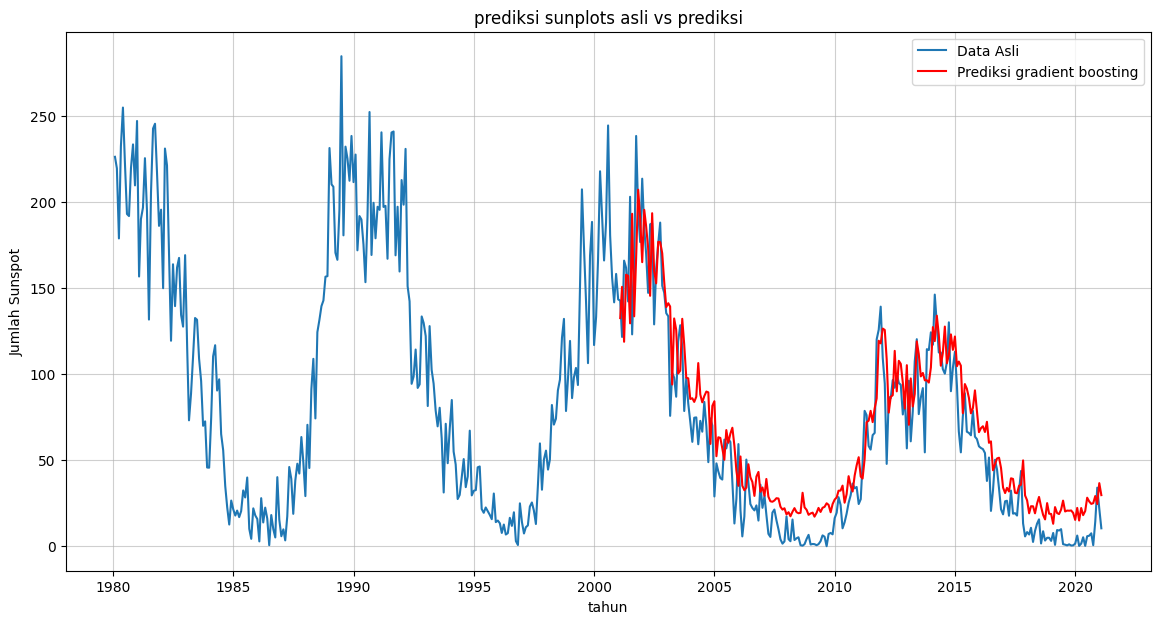

In [30]:
result = pd.DataFrame({'Asli': y_test, 'Prediksi':predictions},index=y_test.index)

plt.figure(figsize=(14, 7))
plt.plot(df['Sunspots']['1980':], label='Data Asli')
plt.plot(result['Prediksi'], label='Prediksi gradient boosting', color='red')
plt.title('prediksi sunplots asli vs prediksi')
plt.xlabel('tahun')
plt.ylabel('Jumlah Sunspot')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


In [32]:
print("Melakukan forecast untuk masa depan...")
last_data = df.iloc[-1]
future_forecasts = []
current_fuatures = last_data[features].values.reshape(1, -1)
last_known_sunspot = last_data['Sunspots']
history = list(df['Sunspots'].values)

Melakukan forecast untuk masa depan...


In [ ]:
n_forecast = 60
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='M')

for i in range(n_forecast):
    # Prediksi 1 langkah ke depan
    next_pred = gbr.predict(current_features)[0]
    future_forecasts.append(next_pred)

    # Update history dengan nilai prediksi baru
    history.append(next_pred)

    # menyiapkan fitur untuk langkah berikutnya
    # 1. Dapatkan tanggal baru
    next_date = forecast_index[i]

    # 2. Buat fitur lag dari history yang sudah diupdate
    new_lags = history[-12:] # Ambil 12 nilai terakhir
    new_lags.reverse()

    # 3. Buat fitur rolling mean
    new_rolling_mean = np.mean(history[-13:-1]) # Rata-rata 12 bulan sebelum prediksi

    # 4. Gabungkan semua fitur baru
    current_features = np.array([[next_date.year, next_date.month, new_rolling_mean] + new_lags]).reshape(1, -1)

forecast_df = pd.Series(future_forecasts, index=forecast_index)

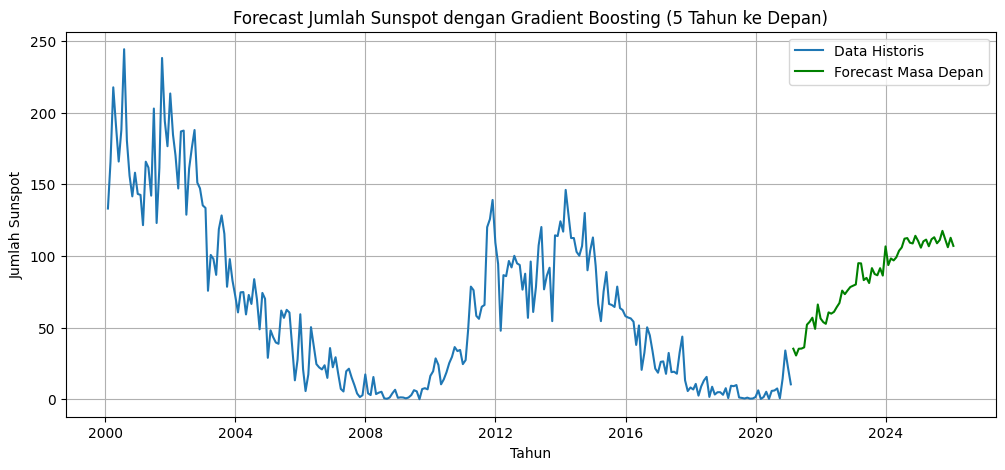

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(df['Sunspots']['2000':], label='Data Historis')
plt.plot(forecast_df, label='Forecast Masa Depan', color='green')
plt.title('Forecast Jumlah Sunspot dengan Gradient Boosting (5 Tahun ke Depan)')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Sunspot')
plt.legend()
plt.grid(True)
plt.show()